In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

import torch.nn as nn

In [2]:
def decode_to_code(encoded_circuit):
    weight_idx = 0
    for encoded_gate in encoded_circuit:
        wire2  = encoded_gate % 10
        wire1 = (encoded_gate // 10) % 10
        gate = (encoded_gate // 100) % 10

        if gate == 1:
            print(f"qml.RX(weights[{weight_idx}], wires={wire1})")
            weight_idx += 1
        elif gate == 2:
            print(f"qml.RZ(weights[{weight_idx}], wires={wire1})")
            weight_idx += 1
        elif gate == 3:
            print(f"qml.CNOT(wires=[{wire1}, {wire2}])")
        elif gate == 4:
            print(f"qml.Hadamard(wires={wire1})")
            
c = [231, 113, 313, 211, 433]

decode_to_code(c)

qml.RZ(weights[0], wires=3)
qml.RX(weights[1], wires=1)
qml.CNOT(wires=[1, 3])
qml.RZ(weights[2], wires=1)
qml.Hadamard(wires=3)


In [3]:
n_train    = 500 
n_test     = 100
batch_size = 32
lr         = 0.01
gamma      = 0.96

num_qubits = 4
repetitions = 2
n_weights = 3 * repetitions

n_epochs = 20

resized_x = 14
resized_y = resized_x

In [4]:
dev = qml.device('lightning.qubit', wires=4)

@qml.qnode(dev,interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)

    for i in range (repetitions):
        qml.CNOT(wires=[0, 2])
        qml.CNOT(wires=[1, 3])
        qml.RZ(weights[0+i], wires=3 -i)
        qml.RX(weights[1 + i], wires=1- i)
        qml.CNOT(wires=[3-i, 2- i])
        qml.CNOT(wires=[1, 0])
        qml.RZ(weights[2+ i], wires=1-i)
        qml.Hadamard(wires=3-i)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [5]:
def load_dataset(n_train, n_test, batch_size):
    """
    Loads train & test sets from MNIST with user-specified sizes.

    Args:
        n_train (int): Desired number of samples in the training set.
        n_test (int): Desired number of samples in the testing set.
        batch_size (int): Batch size for the DataLoaders.

    Returns:
        tuple: (train_loader, test_loader) where each loader is a
               torch.utils.data.DataLoader.
    """
    # Define transformations for the dataset
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5,), (0.5,)),
                                    transforms.Lambda(lambda img: F.interpolate(img.unsqueeze(0), size=(resized_x, resized_y), 
                                        mode='bilinear', align_corners=False).squeeze(0))])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Subset the datasets to the desired number of samples
    train_subset = torch.utils.data.Subset(train_dataset, range(n_train))
    test_subset = torch.utils.data.Subset(test_dataset, range(n_test))

    # Create DataLoaders for training and testing sets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

    print("Number of training samples:", len(train_subset))
    print("Number of test samples:", len(test_subset))

    return train_loader, test_loader


/var/folders/pc/01wnjzvx01n_gqvkhmw2_9nr0000gn/T/ipykernel_13512/3623739010.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


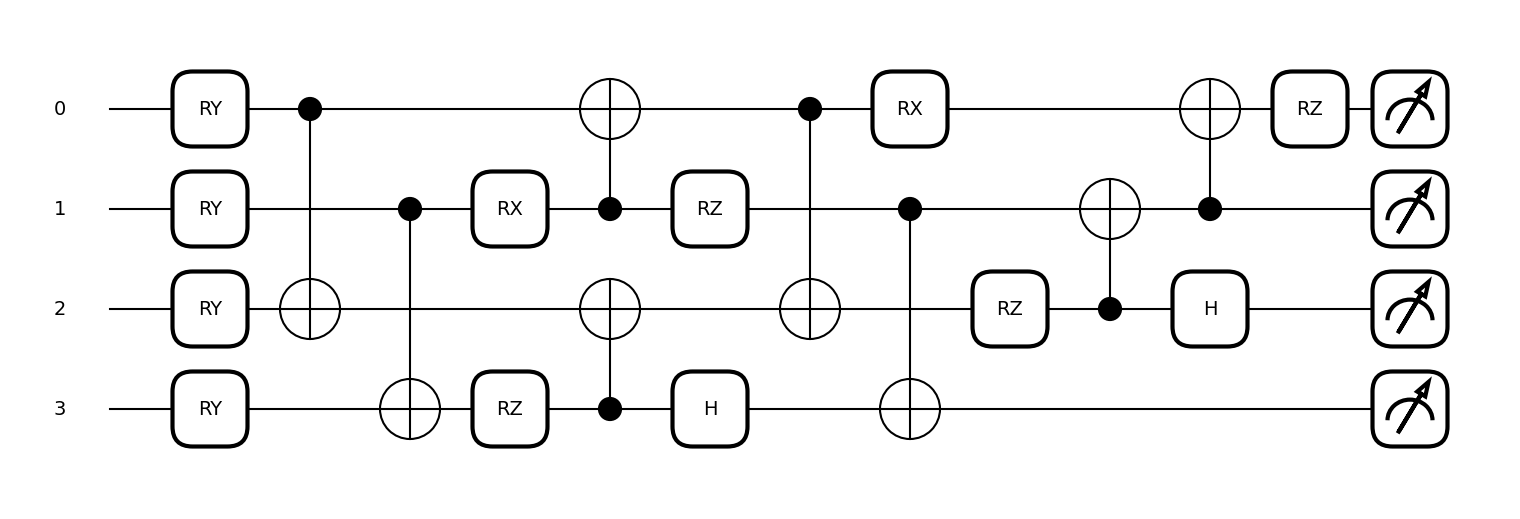

In [6]:
qlayer = qml.qnn.TorchLayer(circuit, {"weights": (n_weights,)})
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], [1,2,3,4,5,123,2,23,1,1,1,1,1,1])
fig.show()

In [7]:
def extract_image_patches(x):
    # Do TF 'SAME' Padding
    B, C, H, W = x.shape  
    #x = torch.arange(B*C*H*W).view(B, C, H, W)
    kernel_h, kernel_w = 2, 2
    stride = 2

    patches = x.unfold(2, kernel_h, stride).unfold(3, kernel_w, stride)
      
    patches = patches.contiguous().view(B, H // stride, W // stride, -1)

    return patches.reshape(-1, 4)

In [8]:
dim = resized_x // 2
class HQNN(nn.Module):
    def __init__(self):
        super(HQNN, self).__init__()

        # Quanvolutional layer (Maps 1 input channel to 4 output channels)
        self.quanv = qlayer

        # Fully connected layer to perform the final classification
        self.fc1 = nn.Linear(dim * dim * 4, 10)  # Assuming 10 output classes

    def forward(self, input):
        patches = extract_image_patches(input)  

        quanvoluted_patches = torch.stack([self.quanv(patch) for patch in patches])
        x = quanvoluted_patches.reshape(input.shape[0], dim, dim, 4)

        x = x.view(-1, dim * dim * 4)  # Flatten for the fully connected layer
        x = self.fc1(x)
        x = F.softmax(x, dim=1)  # Apply softmax
        return x

In [9]:
loss_fn = F.cross_entropy
train_loader, test_loader = load_dataset(n_train, n_test, batch_size)

Number of training samples: 500
Number of test samples: 100


In [10]:
def append_data_to_markdown_table(file_path, circuit, lr, gamma, batch_size, val_loss, val_acc):
    """
    Appends variables to an existing Markdown table in a file, formatting floats to 3 decimal places.

    Args:
        file_path (str): The path to the Markdown file.
        lr (float): The learning rate value.
        gamma (float): The gamma value.
        batch_size (int): The batch size value.
        val_loss (float): The validation loss value.
        val_acc (float): The validation accuracy value.
    """

    with open(file_path, 'a') as f:  # Open the file in append mode
        row = f"| {circuit} | {lr} | {gamma:.2f} | {batch_size} | {val_loss:.3f} | {val_acc:.2f} |\n"
        f.write(row)  # Write the new row of data
        
lr_values    = [0.01, 0.01, 0.007, 0.007, 0.005, 0.005, 0.003, 0.003]
gamma_values = [0.98, 0.96, 0.96, 0.98, 0.98, 0.96, 0.98, 0.96] 

for lr, gamma in zip(lr_values, gamma_values):
    for _ in range(3):
        model = HQNN() 
        optimizer = torch.optim.Adam(model.parameters(), lr =lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) 
        for epoch in range(n_epochs):
            # ---- Training Phase ----
            running_loss = 0.0 
            correct = 0  
            total = 0
            train_losses = []
            test_losses = []
            start_time = time.time()
            for i, (images, labels) in enumerate(train_loader):
                # --- 2. Forward Pass ---
                outputs = model(images)

                # --- 3. Loss Calculation ---
                loss = loss_fn(outputs, labels)
                train_losses.append(loss.item())
                # --- 4. Backpropagation and Optimization ---
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()  
                train_losses.append(loss.item())  # Store loss for each batch

                # Accuracy calculation for the epoch
                _, predicted = torch.max(outputs.data, 1) 
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            scheduler.step() 

            # Print statistics for the epoch
            epoch_loss = sum(train_losses) / len(train_losses)  
            epoch_acc = 100 * correct / total 

            current_lr = scheduler.get_last_lr()[0]  

            # Periodic Evaluation and Logging
            print(f'[i] Epoch {epoch + 1}\n\tLoss: {epoch_loss:.4f}\tAccuracy: {epoch_acc :.2f}%\n\tElapsed Time: {time.time() - start_time:.2f}s')
            print(f'\tLearning Rate: {current_lr}\n')

        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():  # Disable gradients for evaluation
            val_correct = 0
            val_total = 0

            for images, labels in test_loader:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_losses.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = sum(test_losses) / len(test_losses)
        val_acc = 100 * val_correct / val_total 

        print(f'[i] Val Loss: {val_loss:.4f}\t Val Accuracy: {val_acc :.2f}%')
        append_data_to_markdown_table("results500.md", "circ3_SE", lr, gamma, batch_size, val_loss, val_acc)

[i] Epoch 1
	Loss: 2.2755	Accuracy: 14.40%
	Elapsed Time: 26.62s
	Learning Rate: 0.0098

[i] Epoch 2
	Loss: 2.1529	Accuracy: 41.00%
	Elapsed Time: 26.54s
	Learning Rate: 0.009604

[i] Epoch 3
	Loss: 2.0040	Accuracy: 61.40%
	Elapsed Time: 26.98s
	Learning Rate: 0.009411919999999999

[i] Epoch 4
	Loss: 1.9004	Accuracy: 66.80%
	Elapsed Time: 26.80s
	Learning Rate: 0.009223681599999999

[i] Epoch 5
	Loss: 1.8470	Accuracy: 70.20%
	Elapsed Time: 26.54s
	Learning Rate: 0.009039207967999998

[i] Epoch 6
	Loss: 1.8087	Accuracy: 71.40%
	Elapsed Time: 27.03s
	Learning Rate: 0.008858423808639998

[i] Epoch 7
	Loss: 1.7787	Accuracy: 73.60%
	Elapsed Time: 27.05s
	Learning Rate: 0.008681255332467197

[i] Epoch 8
	Loss: 1.7571	Accuracy: 77.20%
	Elapsed Time: 27.03s
	Learning Rate: 0.008507630225817853

[i] Epoch 9
	Loss: 1.7363	Accuracy: 78.40%
	Elapsed Time: 26.48s
	Learning Rate: 0.008337477621301496

[i] Epoch 10
	Loss: 1.7196	Accuracy: 80.20%
	Elapsed Time: 26.98s
	Learning Rate: 0.008170728068875